In [1]:
# Part3. Feature Engineering based on external sources. More EDA. Time Series & NLP

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.linear_model

## Feature Optimization

In [2]:
#import the dataframe with added features from a csv file
df = pd.read_csv("ufo_reports.csv", sep='\t')
df=df[(~df.Long.isnull()) & (~df.Lat.isnull())]

In [3]:
#Create dummy variables for some of the categorical variables: Shape
shapes = pd.get_dummies(df.Shape,prefix='Shape').iloc[:,0:]

In [4]:
# df=pd.concat([df,shapes],axis=1)
cols_to_keep=['Date', 'Year', 'Month', 'Day', 'Time', 'City', 'State', 'Lat', 'Long', 'Shape',
       'Duration_Sec', 'Summary', 'WeekDay', 'Week', 'Quarter', 'TimePer', 'state', 'state abbr', 'Region',
       'Hoax', 'ASTR','HOL', 'Pop', 'Milit_Share']
df = df[cols_to_keep].join(shapes.ix[:, 'Shape_Chevron':])

In [5]:
#Create dummy variables for some of the categorical variables: Region
regions = pd.get_dummies(df.Region,prefix='Region').iloc[:,0:]

In [6]:
cols_to_keep=['Date', 'Year', 'Month', 'Day', 'Time', 'City', 'State', 'Lat', 'Long','Shape',
       'Duration_Sec', 'Summary', 'WeekDay', 'Week', 'Quarter', 'TimePer',
       'state', 'state abbr', 'Region', 'Hoax', 'ASTR','HOL', 'Pop', 'Milit_Share',
       'Shape_Chevron','Shape_Cigar', 'Shape_Circle', 'Shape_Cone', 'Shape_Cross',
       'Shape_Cylinder', 'Shape_Diamond', 'Shape_Disk', 'Shape_Egg',
       'Shape_Fireball', 'Shape_Flash', 'Shape_Formation', 'Shape_Light',
       'Shape_Other', 'Shape_Oval', 'Shape_Rectangle', 'Shape_Sphere',
       'Shape_Teardrop', 'Shape_Triangle']
df = df[cols_to_keep].join(regions.ix[:, 'Region_Midwest':])

## Feature Selection


### -Correlation

Axes(0.125,0.125;0.62x0.775)


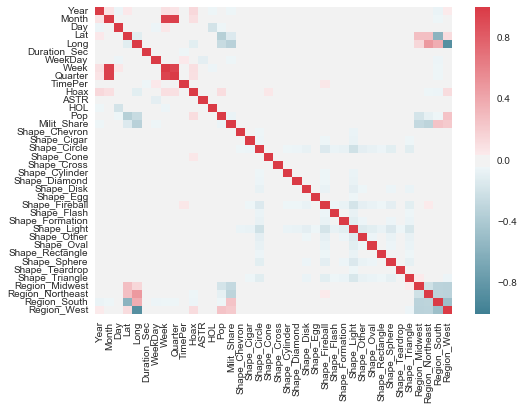

In [7]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True)

correlations = df.corr()
# print (correlations)
print (sns.heatmap(correlations, cmap=cmap))

In [8]:
df.columns
df = df.reset_index()

In [9]:
df_copy = pd.DataFrame(df)
df_copy.set_index('Date',inplace=True)
df_copy.index = pd.to_datetime(df_copy.index, unit='s')
df_copy.head()

,index,Year,Month,Day,Time,City,State,Lat,Long,Shape,...,Shape_Other,Shape_Oval,Shape_Rectangle,Shape_Sphere,Shape_Teardrop,Shape_Triangle,Region_Midwest,Region_Northeast,Region_South,Region_West
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,0,2015,12,31,23:59,Eugene,OR,44.052069,-123.086746,Fireball,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-31,1,2015,12,31,15:00,Monmouth,OR,44.848449,-123.233987,Egg,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-30,2,2015,12,30,22:00,Portland,OR,45.523447,-122.676207,Light,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-30,3,2015,12,30,19:30,Springfield,OR,44.046237,-123.022028,Changing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-30,4,2015,12,30,16:50,Orient,OR,45.467337,-122.352587,Cylinder,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# list of astronomical events
ASTR=[
'2014-05-06','2014-01-01','2014-01-02','2014-01-03','2014-01-05','2014-01-16','2014-01-30',
'2014-02-14',
'2014-03-01','2014-03-16','2014-03-20','2014-03-30',
'2014-04-08','2014-04-15','2014-04-23','2014-04-22','2014-04-29',
'2014-05-05','2014-05-10','2014-05-14','2014-05-24','2014-05-28',
'2014-06-07','2014-06-13','2014-06-21','2014-06-27',
'2014-07-12','2014-07-26','2014-07-29','2014-07-28',
'2014-08-10','2014-08-12','2014-08-18','2014-08-25','2014-08-29','2014-08-13',
'2014-09-09','2014-09-23','2014-09-24',
'2014-10-04','2014-10-07','2014-10-08','2014-10-09','2014-10-21','2014-10-20','2014-10-23',
'2014-11-05','2014-11-06','2014-11-17','2014-11-18','2014-11-22',
'2014-12-06','2014-12-13','2014-12-14','2014-12-21','2014-12-22','2014-12-23','2014-12-22',
'2015-01-03','2015-01-04','2015-01-05','2015-01-20',
'2015-02-03','2015-02-06','2015-02-18','2015-02-22','2015-2-024',
'2015-03-05','2015-03-06','2015-03-20',
'2015-04-04','2015-04-13','2015-04-18','2015-04-22','2015-04-23','2015-04-25',
'2015-05-04','2015-05-05','2015-05-06','2015-05-07','2015-05-18','2015-05-23',
'2015-06-02','2015-06-06','2015-06-16','2015-06-21','2015-06-24',
'2015-07-01','2015-07-02','2015-07-14','2015-07-16','2015-07-28','2015-07-29','2015-07-31',
'2015-08-12','2015-08-13','2015-08-14','2015-08-29',
'2015-09-01','2015-09-04','2015-09-13','2015-09-23','2015-09-28',
'2015-10-01','2015-10-08','2015-10-11','2015-10-16','2015-10-13','2015-10-22','2015-10-21','2015-10-26','2015-10-27','2015-10-28',
'2015-11-06','2015-11-05','2015-11-07','2015-11-11','2015-11-18','2015-11-17','2015-11-25',
'2015-12-07','2015-12-11','2015-12-13','2015-12-14','2015-12-22','2015-12-21','2015-12-25','2015-12-29'
]

In [11]:
#list of US federal holidays
holiday=[
'2014-01-01','2014-01-20','2014-02-17','2014-03-04','2014-03-17','2014-03-09','2014-05-26',
'2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25'    
'2015-01-01','2015-01-19','2015-02-16','2015-05-25','2015-07-04','2015-09-07',
'2015-10-12','2015-11-11','2015-11-26','2015-12-25'
]

In [12]:
def MATCH(a, LIST):
    if a in LIST:
        return 1
    else:
        return 0

In [13]:
#Add columns based on the match with astronomical events and holidays
df_day = df_copy[['Time']].resample('D', how='count')
df_day['Date'] = df_day.index
df_day['ASTR'] = df_day['Date'].apply(lambda x : MATCH(str(x).split(' ')[0], ASTR))
df_day['HOL'] = df_day['Date'].apply(lambda x : MATCH(str(x).split(' ')[0], holiday))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  from ipykernel import kernelapp as app


In [15]:
#Identify top 5 dates based on the report count
df_day.sort(['Time'],ascending=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Time,Date,ASTR,HOL
Date,,,,
2015-11-07,275,2015-11-07,1,0
2014-07-04,203,2014-07-04,0,1
2015-07-04,158,2015-07-04,0,1
2014-07-05,91,2014-07-05,0,0
2014-01-01,81,2014-01-01,1,1
2015-09-27,67,2015-09-27,0,0
2014-07-12,55,2014-07-12,1,0
2014-06-21,49,2014-06-21,1,0
2015-01-01,49,2015-01-01,0,0


In [15]:
def draw_astr_time(): 
    astr_time = []
    for d in df_day['Date']:
        t = int(df_day[df_day.Date== d].Time[0])
        a = int(df_day[df_day.Date == d].ASTR[0])
    
        astr_time.append(a*t)  
    return(astr_time)

def draw_holiday_time(): 
    astr_time = []
    for d in df_day['Date']:
        t = int(df_day[df_day.Date== d].Time[0])
        a = int(df_day[df_day.Date == d].HOL[0])
    
        astr_time.append(a*t)  
    return(astr_time)

df_day['ASTR_TIME'] = draw_astr_time() 
df_day['HOL_TIME']=draw_holiday_time()

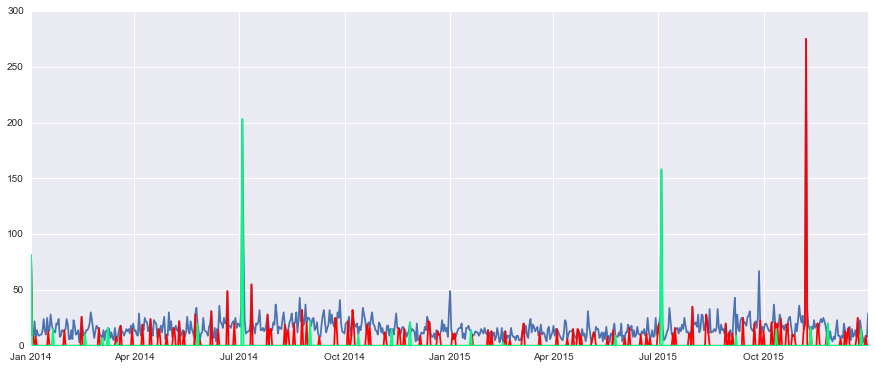

In [16]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.plot(df_day['Time'])
plt.plot( df_day['ASTR_TIME'], 'r-')
plt.plot( df_day['HOL_TIME'], '#00ff7f',linestyle='-')

### - Poisson Regression on number of reports 

In [17]:
from datetime import datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

#df['Hoax'] =df['Hoax'].apply(lambda x: binary_convert(x))

df_day['Date'] = df_day.index
df_day['Date'] = df_day['Date'].apply(lambda x: str(x).split(' ')[0])
df_day['Diff'] = df_day['Date'].apply(lambda x: days_between(str(x), '2014-01-01'))

(array([  14.,  128.,  227.,  166.,  107.,   48.,   22.,    6.,    3.,
           2.,    0.,    1.,    0.,    1.,    0.,    0.,    1.,    0.,
           1.,    0.]),
 array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 <a list of 20 Patch objects>)

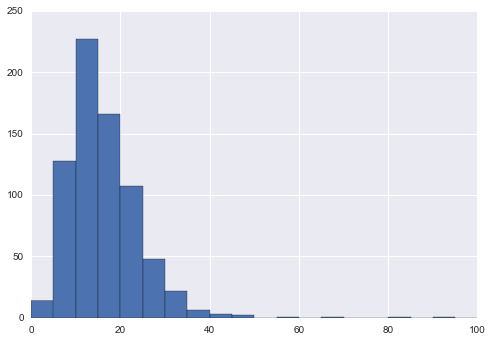

In [18]:
plt.hist(df_day['Time'],range=[0,100],bins=20)

In [19]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

y = df_day['Time']
X = df_day[['Diff','HOL', 'ASTR']]
X = sm.add_constant(X)
model = sm.Poisson(y,X)
result = model.fit()
print (result.summary())

ypred = result.predict(X)
print (ypred)

         Current function value: 5.363886
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:                   Time   No. Observations:                  730
Model:                        Poisson   Df Residuals:                      726
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Aug 2016   Pseudo R-squ.:                 0.03467
Time:                        18:50:12   Log-Likelihood:                -3915.6
converged:                      False   LL-Null:                       -4056.3
                                        LLR p-value:                 1.114e-60
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.7572      0.019    148.824      0.000         2.721     2.794
Diff        1.919e-05   4.29e-05      0.447      0.655      -6.5e

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


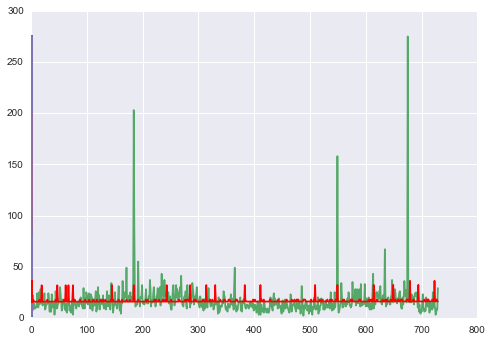

In [20]:
fig, ax = plt.subplots()
ax.plot(X, y)
ax.plot(X, ypred, 'r')

In [21]:
from scipy import stats
rate = int(df_day['Time'].mean())
y0 = stats.poisson.pmf(df_day['Time'],rate)
print ('rate:', rate)

('rate:', 16)


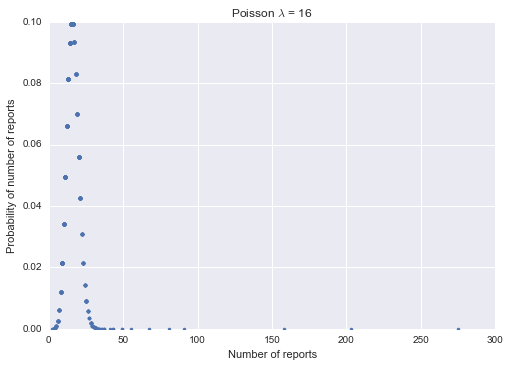

In [22]:
plt.plot(df_day['Time'],y0,'.')
plt.title('Poisson $\lambda$ = %i' % rate)
plt.xlabel('Number of reports')
plt.ylabel('Probability of number of reports')
plt.show()

###  -Time series analysis on the number of reports

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:2476: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


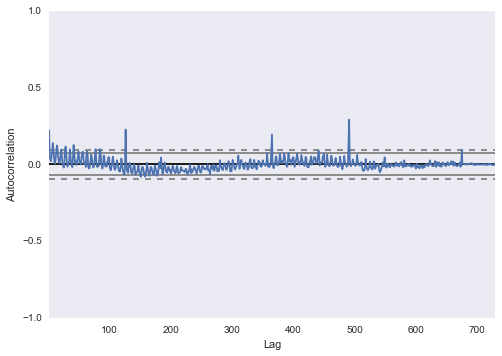

In [23]:
from pandas.tools.plotting import autocorrelation_plot
def grid_search_corr(x, num, lag_limit):
    corr = {}
    
    for l in range(1,num):
        c = x['Time'].autocorr(l)
        if c > lag_limit:
            corr[l]= x['Time'].autocorr(l)
    return corr

grid_search_corr(df_day,730,0.3)
autocorrelation_plot(df_day['Time'])

In [24]:
def grid_search_corr(x, num, lag_limit):
    corr = {}
    
    for l in range(1,num):
        c = x['Time'].autocorr(l)
        if c > lag_limit:
            corr[l]= x['Time'].autocorr(l)
    return corr

grid_search_corr(df_day,730,0.3)

{126: 0.31267447066598159,
 365: 0.40931385365158279,
 491: 0.65600409286070172,
 675: 0.78459886975651016,
 691: 0.45982206337603287,
 720: 0.41415259495404982,
 722: 0.38950834679729723}

In [25]:
from sklearn.metrics import mean_absolute_error
n = len(df_day.Time)
train = df_day.Time[:int(.75*n)].apply(lambda x: np.float64(x))
test = df_day.Time[int(.75*n):].apply(lambda x: np.float64(x))

In [26]:
from sklearn.metrics import mean_absolute_error
err_list={}
for p in range(1,5):
    for q in range (0,3):
        model_arima=sm.tsa.ARIMA(train,(p,0,q)).fit()
        model_arima.summary()
        predictions = model_arima.predict(
            '2015-07-02',
            '2015-12-31',
            dynamic=True,
        )
        err_list[p,q]= mean_absolute_error(test, predictions)
        print 'p=', p, 'q=', q,'Mean absolute error:', err_list[p,q]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


p= 1 q= 0 Mean absolute error: 8.08425003716
p= 1 q= 1 Mean absolute error: 8.08006079193
p= 1 q= 2 Mean absolute error: 8.24736708235
p= 2 q= 0 Mean absolute error: 8.08148445687
p= 2 q= 1 Mean absolute error: 8.07951987759
p= 2 q= 2 Mean absolute error: 8.25101042478
p= 3 q= 0 Mean absolute error: 8.07862103857
p= 3 q= 1 Mean absolute error: 8.23425630071


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p= 3 q= 2 Mean absolute error: 8.12534239304
p= 4 q= 0 Mean absolute error: 8.07970235748
p= 4 q= 1 Mean absolute error: 8.22271003194
p= 4 q= 2 Mean absolute error: 8.23471440336


In [27]:
print 'best model:', min(err_list.items(), key=lambda x: x[1]) 

best model: ((3, 0), 8.0786210385694019)


In [28]:
model_arima = sm.tsa.ARIMA(train,(3,0,0)).fit()
predictions = model_arima.predict(
            '2015-07-02',
            '2015-12-31',
            dynamic=True,
        )

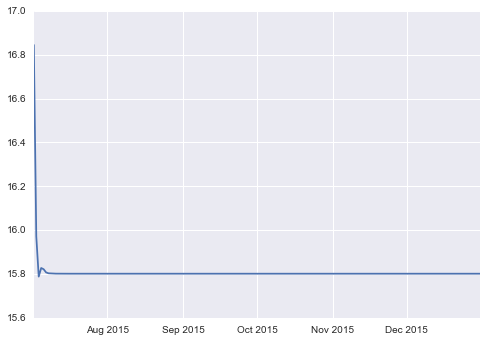

In [29]:
plt.plot(predictions)

NameError: name 'predictions0' is not defined

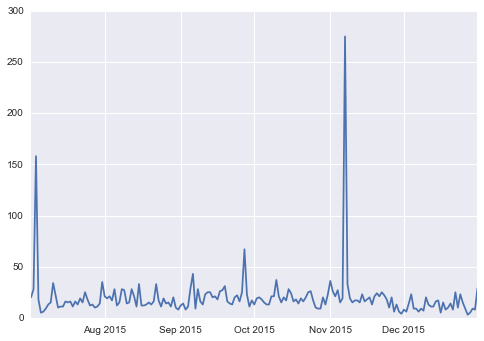

In [30]:
fig, ax = plt.subplots()
ax.plot(test)
ax.plot(predictions0)

In [31]:
model_arima_best = sm.tsa.ARIMA(train, (3,0,0)).fit()
model_arima_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Time   No. Observations:                  547
Model:                     ARMA(3, 0)   Log Likelihood               -2068.325
Method:                       css-mle   S.D. of innovations             10.613
Date:                Tue, 30 Aug 2016   AIC                           4146.649
Time:                        18:50:32   BIC                           4168.172
Sample:                    01-01-2014   HQIC                          4155.062
                         - 07-01-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.8012      0.741     21.326      0.000        14.349    17.253
ar.L1.Time     0.4350      0.044      9.818      0.000         0.348     0.522
ar.L2.Time    -0.0925      0.048     -1.919      0.055        -0.187     0.002
ar.L3.Time     0.0457      0.044      1.031      0.303        -0.041     0.133
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2068           -0.0000j            2.2068           -0.0000
AR.2           -0.0902           -3.1490j            3.1503           -0.2546
AR.3           -0.0902           +3.1490j            3.1503            0.2546
-----------------------------------------------------------------------------
"""

In [32]:
df=df.reset_index()
df.head(1)
df.columns

Index([u'Date', u'index', u'Year', u'Month', u'Day', u'Time', u'City',
       u'State', u'Lat', u'Long', u'Shape', u'Duration_Sec', u'Summary',
       u'WeekDay', u'Week', u'Quarter', u'TimePer', u'state', u'state abbr',
       u'Region', u'Hoax', u'ASTR', u'HOL', u'Pop', u'Milit_Share',
       u'Shape_Chevron', u'Shape_Cigar', u'Shape_Circle', u'Shape_Cone',
       u'Shape_Cross', u'Shape_Cylinder', u'Shape_Diamond', u'Shape_Disk',
       u'Shape_Egg', u'Shape_Fireball', u'Shape_Flash', u'Shape_Formation',
       u'Shape_Light', u'Shape_Other', u'Shape_Oval', u'Shape_Rectangle',
       u'Shape_Sphere', u'Shape_Teardrop', u'Shape_Triangle',
       u'Region_Midwest', u'Region_Northeast', u'Region_South',
       u'Region_West'],
      dtype='object')

### - Hypothesis: The military percentage and the number of ufo reports are correlated

In [33]:
df_day0 = df_copy[['Time']].resample('W', how='count')
df_day0.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  if __name__ == '__main__':


,Time
Date,
2014-01-05,128
2014-01-12,91
2014-01-19,122
2014-01-26,111
2014-02-02,108


             state_count  milit_share
state_count     1.000000    -0.105667
milit_share    -0.105667     1.000000


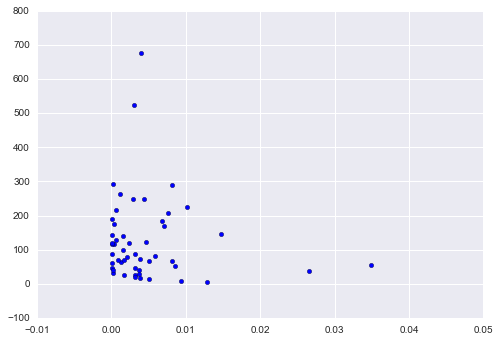

             state_count  milit_share
state_count     1.000000    -0.148136
milit_share    -0.148136     1.000000


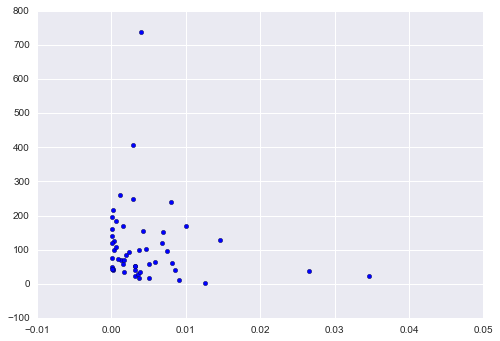

In [34]:
def state_milit(year):
    df_year=df[df.Year== year]
    milit_year = []
    state_count = []
    df_state_milit={}
    
    for state in df['State'].unique():
        milit_year.append(df_year[df_year.State== state].iloc[0].Milit_Share)
        state_count.append(df_year[df_year.State==state].Year.count())
        
    df_state_milit['state']=df['State'].unique()    
    df_state_milit['state_count']=state_count
    df_state_milit['milit_share']=milit_year
    features0 = ['state','state_count', 'milit_share']
    df_state_milit=pd.DataFrame(df_state_milit, columns=features0)
    return df_state_milit

print state_milit(2014).corr()
plt.scatter(state_milit(2014)['milit_share'],state_milit(2014)['state_count'])
plt.show()
print state_milit(2015).corr()
plt.scatter(state_milit(2015)['milit_share'],state_milit(2015)['state_count'])
plt.show()

In [35]:
df_copy.columns

Index([u'index', u'Year', u'Month', u'Day', u'Time', u'City', u'State', u'Lat',
       u'Long', u'Shape', u'Duration_Sec', u'Summary', u'WeekDay', u'Week',
       u'Quarter', u'TimePer', u'state', u'state abbr', u'Region', u'Hoax',
       u'ASTR', u'HOL', u'Pop', u'Milit_Share', u'Shape_Chevron',
       u'Shape_Cigar', u'Shape_Circle', u'Shape_Cone', u'Shape_Cross',
       u'Shape_Cylinder', u'Shape_Diamond', u'Shape_Disk', u'Shape_Egg',
       u'Shape_Fireball', u'Shape_Flash', u'Shape_Formation', u'Shape_Light',
       u'Shape_Other', u'Shape_Oval', u'Shape_Rectangle', u'Shape_Sphere',
       u'Shape_Teardrop', u'Shape_Triangle', u'Region_Midwest',
       u'Region_Northeast', u'Region_South', u'Region_West'],
      dtype='object')

#### -NLP on Summary

In [36]:
from nltk.stem import PorterStemmer
import re
summary=df['Summary'].fillna('')
sum_stem=[]
stemmer = PorterStemmer()
for s in summary: 
    try:
        res = ",".join([stemmer.stem(kw) for kw in re.findall(r"[\w]+", s)])
        sum_stem.append(res)
        print res
    except UnicodeDecodeError:
        sum_stem.append('')
        print res

View,4,slow,move,orang,ish,orb,on,new,year,eve,move,from,E,to,W,until,they,disappear,on,the,horizon
A,white,balloon,give,off,a,bright,blue,light,and,disappear,along,with,the,balloon
Dozen,red,green,blue,light,in,portland,sky,that,spin,with,two,bright,white,light,that,move,NUFORC,Note,Star,PD
Shape,chang,UFO,s,in,Springfield,Oregon
While,drive,at,sunset,I,saw,a,hover,vertic,cylindr,object,glow,in,the,sun,which,then,separ,into,two,object
There,were,8,med,height,fli,object,evenli,space,in,format,with,no,sound,and,no,flash,light,the,orang,light,were,steadi
Christma,wa,just,over,I,step,out,to,smoke,in,the,cold,I,focus,on,a,bright,star,that,seem,to,b,flicker,I,lost,contact
5,orang,glow,light,seen,by,2,wit,head,south,to,north,over,Bend,Oregon,on,Christma,Eve,2015
Pulsat,light,in,SW,sky,over,Beaveton,Farmington,area
Saw,bright,white,circl,hover,then,shot,up,straight,fast,fast,then,dart,sideway,unlik,ani,craft,or,drone,ive,ever,seen
We,live,off,of,201st,and,baselin,we,saw,a,point,with,a,thin,ta

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics

vectorizer = CountVectorizer(stop_words='english',
                             min_df=3,
                             max_df=0.7,
                             )

vectorizer.fit(sum_stem)

sparse_data = vectorizer.transform(summary)
pd.DataFrame(sparse_data.todense(), columns=vectorizer.get_feature_names()).head()


,00,000,00pm,01,02,03,04,05,06,07,...,youtu,youtub,yr,zag,zero,zig,zigzag,zip,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
from gensim.models.ldamodel import LdaModel #https://radimrehurek.com/gensim/models/ldamodel.html
from gensim.matutils import Sparse2Corpus #https://radimrehurek.com/gensim/matutils.html

# First we convert our word-matrix into gensim's format from Scikit-Learn
# Sparse2Corpus - Convert a matrix in scipy.sparse format into a streaming gensim corpus.
corpus = Sparse2Corpus(sparse_data, documents_columns = False)

# Then we fit an LDA model. num_topics is manually set by us.
# id2word is a mapping from word ids (integers) to words (strings). It is used to determine the 
# vocabulary size, as well as for debugging and topic printing.
# num_topics is the number of requested latent topics to be extracted from the training corpus.

num_topics = 2
lda_model = LdaModel(corpus=corpus, 
                     id2word=dict(enumerate(vectorizer.get_feature_names())), 
                     num_topics=num_topics)

In [40]:
num_words_per_topic = 5
for ti, topic in enumerate(lda_model.show_topics(num_topics = num_topics, num_words = num_words_per_topic)):
    print "Topic: %d" % (ti)
    print topic
    print

Topic: 0
(0, u'0.087*light + 0.078*sky + 0.051*red + 0.051*bright + 0.033*white')

Topic: 1
(1, u'0.029*like + 0.025*object + 0.025*nuforc + 0.025*note + 0.025*pd')



In [ ]:
def feature_words(w, topic):
    '''
    search the description to see the presence or absence.
    [1.0*light + 0.0*sky + 1.0*red + 0.0*bright.. + 75.9*lat + 85.4*long + 1.0*like ]
    '''
    for word in topic:
        if word in w:
            
    